<a href="https://colab.research.google.com/github/anitamezzetti/financial_big_data/blob/main/AnitaVersion_FinBigData_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
student1 = "Anita Mezzetti"
student2 = "Hien Lê"

Complementary stuff:
* Drive Folder to save data, notebooks and models

Note: project has been linked to [Github](https://github.com/anitamezzetti/financial_big_data)!

In [ ]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')
#nb_path = '/content/notebooks2'
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
#sys.path.insert(0,nb_path)

#!pip install --target=$nb_path arrow

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks" # checking the content of the folder

 AnitaVersion_FinBigData_1.ipynb  'complete_mc (2).ipynb'
 CHE.csv			   complete_mc.ipynb
 CHN.csv			  'Copia di mc.ipynb'
 classification_3.ipynb		   generate_dataset_dataset4.ipynb
'classification_4 (1).ipynb'	   generate_dataset.ipynb
 classification_4.ipynb		   JPN.csv
 classification.ipynb		   Untitled
 closed_form_solution.ipynb	  'Untitled (1)'
'complete_mc (1).ipynb'		   USA.csv


In [ ]:
root = "/content/drive/My Drive/Colab Notebooks" 

In [ ]:
!pip install arrow

     |████████████████████████████████| 51kB 2.7MB/s 


## Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# other libraries here
import requests
import arrow

In [ ]:
# The following snippet gets data for the 4 countries from a proxy API, but it seems that the database in this API is not up-to-date
# jh_data = requests.get('https://covid19api.herokuapp.com/confirmed')

# res_dict = jh_data.json()["locations"]
# df_res = pd.json_normalize(res_dict)
# df_res = df_res.drop(columns=["country_code", "latest", "province", "coordinates.latitude", "coordinates.longitude"])

# countries_of_interest = ["US", "Switzerland", "Japan", "China"]

# df_china = df_res[df_res.country == "China"].set_index("country")
# df_china = pd.DataFrame(df_china.sum(axis=0), columns=["China"]).T

# df = df_res[df_res.country.isin(countries_of_interest[:3])].set_index("country")
# df = pd.concat([df, df_china])

In [ ]:
# TODO: we need to decide on a fixed END date - December 1st!

countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-02-25"
end_date = "2020-12-01" # yesterday
dfs = {} # dfs of cumulative confirmed cases
for country in countries_of_interest:
  query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
  res = requests.get(query).json()
  df = pd.DataFrame(res["result"])
  df.index = pd.DatetimeIndex(df["date"], tz="utc")
  df.drop(columns=["date"])
  df["date"] = pd.to_datetime(df["date"])
  df["ts_in_secs"] = df["date"].astype(int)
  df["new_confirmed"] = df["confirmed"].diff().fillna(0)
  df.to_csv(f"{root}/{country}.csv")
  dfs[country] = df

## Analysis

In [ ]:
# dataset for confirmed cases for each country (needed later)
df_confirmed = pd.DataFrame(index = dfs[country].index)
df_total = pd.DataFrame(index = dfs[country].index)

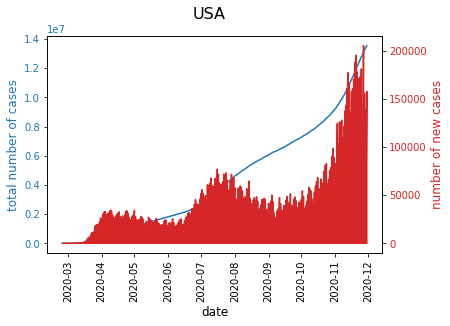

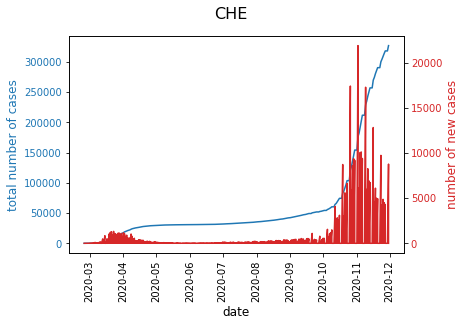

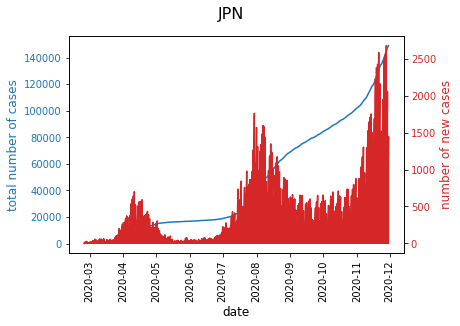

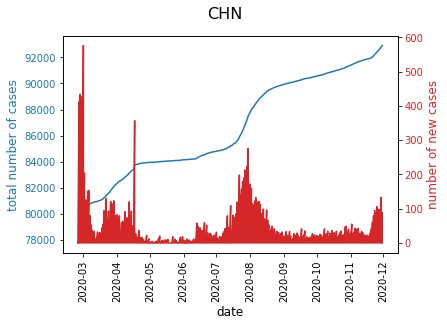

In [ ]:
# first overview
for country,df in dfs.items():  
    fig,ax1 = plt.subplots()
    ax1.plot(df.index, df["confirmed"])
    ax1.set_xlabel("date", size=12)
    ax1.tick_params(labelrotation=90, axis="x")
    color = "tab:blue"
    ax1.set_ylabel("total number of cases", color=color, size=12)
    ax1.tick_params(axis="y", labelcolor=color)

    # add that country to the databases
    df_confirmed[country] = df["new_confirmed"] 
    df_total[country] = df["confirmed"]

    ax2 = ax1.twinx()
    color="tab:red"
    ax2.plot(df.index, df["new_confirmed"], color=color)
    ax2.set_ylabel("number of new cases", color=color, size=12)
    ax2.tick_params(axis="y", labelcolor=color)
    fig.suptitle(country, size=16)

    #fig.tight_layout()  
    plt.show()

### Per month

The boxplots below show (potentially) the month(s) where these countries experienced a jump or a big change in the number of new cases. For example, Switzerland experienced some very fast increase in cases in October and November which caused the boxplots to be so wide and with even outliers.

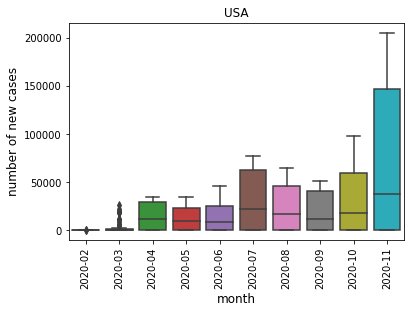

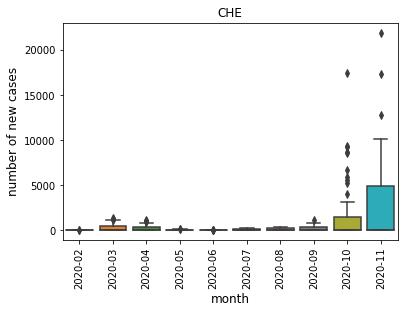

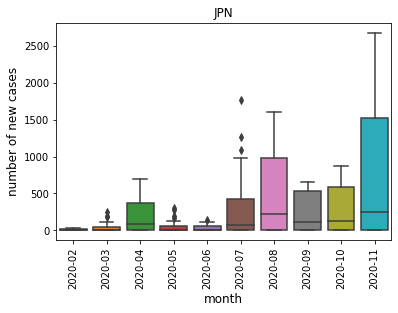

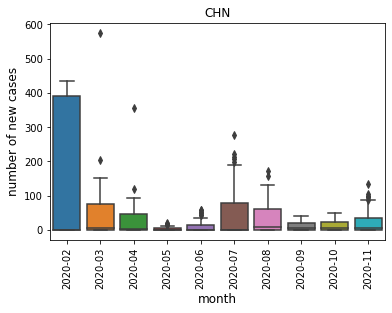

In [ ]:
for country,df in dfs.items():
    df["month"] = df["date"].dt.to_period("M")
    plt.figure()
    sns.boxplot(data=df, x="month", y="new_confirmed")
    plt.xticks(rotation=90)
    plt.xlabel("month", size=12)
    plt.ylabel("number of new cases", size=12)
    plt.title(country)
    plt.show()

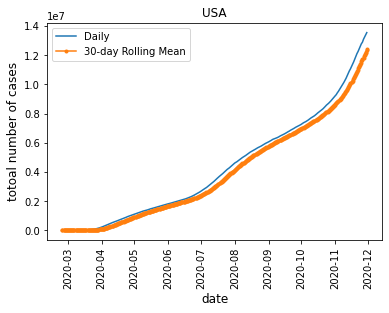

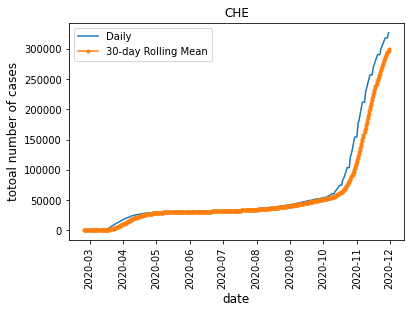

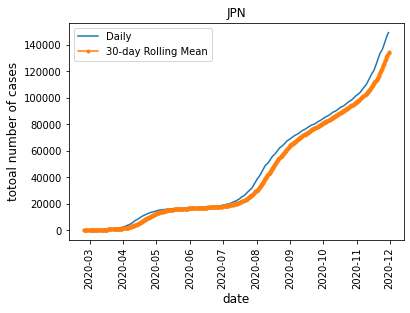

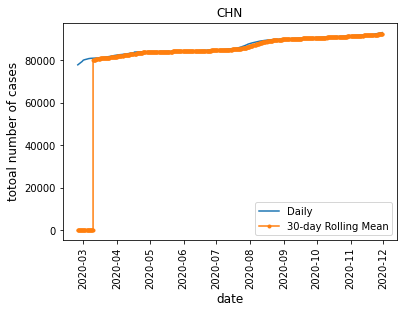

In [ ]:
# rolling for cumulative => solution for the problem of late registration of data or non-granularity

for country,df in dfs.items():
    df_30day_rolling = df["confirmed"].rolling(30).mean().fillna(0)
    plt.figure()
    plt.plot(df.date, df["confirmed"], label="Daily")
    plt.plot(df.date, df_30day_rolling, marker=".", label="30-day Rolling Mean")
    plt.xticks(rotation=90)
    plt.xlabel("date", size=12)
    plt.ylabel("total number of cases", size=12)
    plt.title(country)
    plt.legend()
    plt.show()

### Per period

In [ ]:

mid_period = ("2020-06-12", "2020-10-12")  # arbitrarily chosen, subject to change             
first_period = (start_date, mid_period[0]) # beginning of pandemic
last_period = (mid_period[1], arrow.get(end_date)) # most recent 

In [ ]:
test = dfs["CHE"]
test[test.index > mid_period[0]]

,confirmed,date,deaths,recovered,ts_in_secs,new_confirmed,month
date,,,,,,,
2020-06-13 00:00:00+00:00,31094,2020-06-13,1938,28800,1592006400000000000,31.0,2020-06
2020-06-13 00:00:00+00:00,31094,2020-06-13,1938,28800,1592006400000000000,0.0,2020-06
2020-06-14 00:00:00+00:00,31117,2020-06-14,1938,28800,1592092800000000000,23.0,2020-06
2020-06-14 00:00:00+00:00,31117,2020-06-14,1938,28800,1592092800000000000,0.0,2020-06
2020-06-15 00:00:00+00:00,31131,2020-06-15,1939,28900,1592179200000000000,14.0,2020-06
...,...,...,...,...,...,...,...
2020-11-28 00:00:00+00:00,318290,2020-11-28,4621,222100,1606521600000000000,0.0,2020-11
2020-11-29 00:00:00+00:00,318290,2020-11-29,4650,222100,1606608000000000000,0.0,2020-11
2020-11-29 00:00:00+00:00,318290,2020-11-29,4650,222100,1606608000000000000,0.0,2020-11


## Correlation study New Cases

In [ ]:
df_confirmed.head()

,USA,CHE,JPN,CHN
date,,,,
2020-02-25 00:00:00+00:00,0.0,0.0,0.0,0.0
2020-02-25 00:00:00+00:00,0.0,0.0,0.0,0.0
2020-02-26 00:00:00+00:00,0.0,0.0,19.0,412.0
2020-02-26 00:00:00+00:00,0.0,0.0,0.0,0.0
2020-02-27 00:00:00+00:00,1.0,7.0,26.0,434.0


Normalize data

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_confirmed.values)
df_confirmed_scaled = pd.DataFrame(x_scaled)
df_confirmed_scaled = df_confirmed_scaled.rename(columns={
    0:countries_of_interest[0],
    1:countries_of_interest[1],
    2:countries_of_interest[2],
    3:countries_of_interest[3]
})
df_confirmed_scaled['Date'] = df_confirmed.index
df_confirmed_scaled = df_confirmed_scaled.set_index('Date')
df_confirmed_scaled.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-02-25 00:00:00+00:00,0.000000,0.000000,0.000000,0.001733
2020-02-25 00:00:00+00:00,0.000000,0.000000,0.000000,0.001733
2020-02-26 00:00:00+00:00,0.000000,0.000000,0.007092,0.715771
2020-02-26 00:00:00+00:00,0.000000,0.000000,0.000000,0.001733
2020-02-27 00:00:00+00:00,0.000005,0.000319,0.009705,0.753899


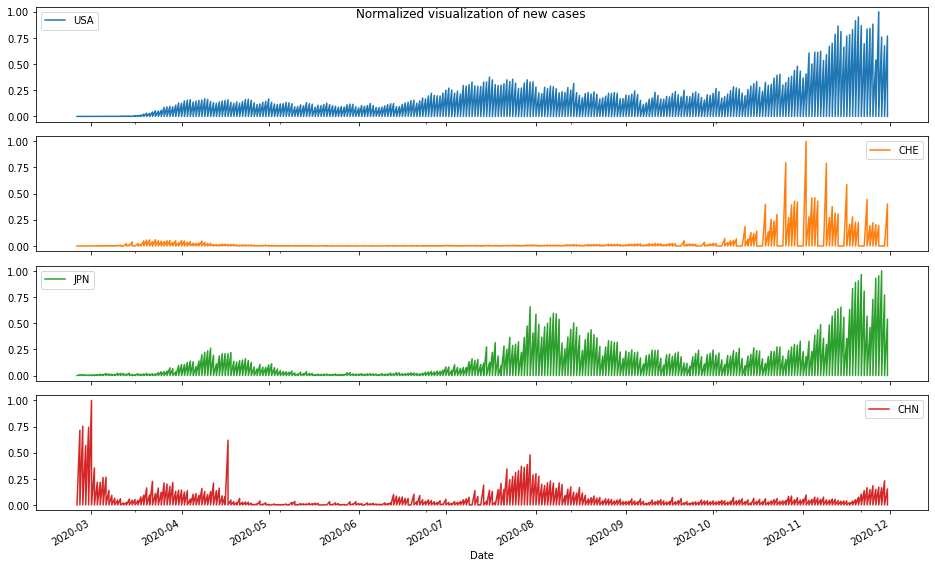

In [ ]:
df_confirmed_scaled.plot(subplots=True, title='Normalized visualization of new cases', figsize=(13,8))
plt.tight_layout()
plt.show()

### Correlation matrix of new cases among different countries

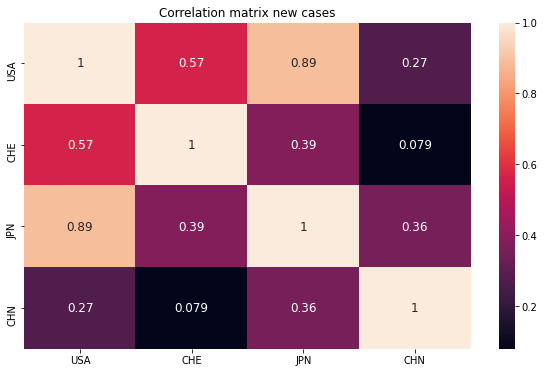

In [ ]:
corr = df_confirmed_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.title('Correlation matrix new cases')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### ACF function



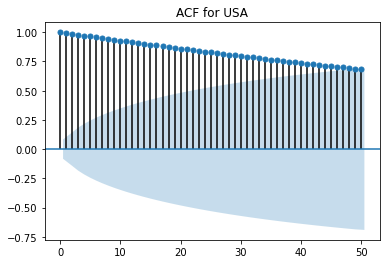

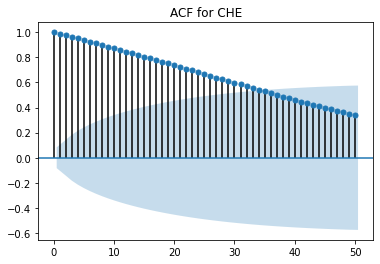

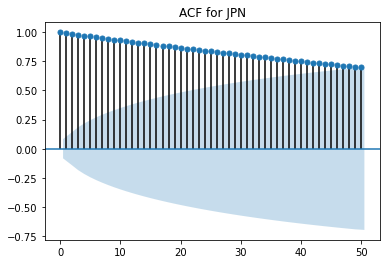

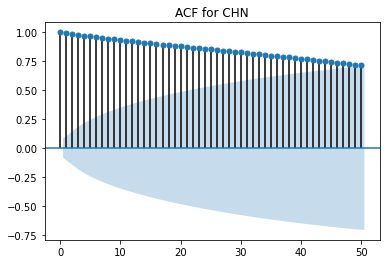

In [ ]:
import statsmodels.api as sm


for country in df_confirmed_scaled:
    sm.graphics.tsa.plot_acf(df_total_scaled[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()

 each value is highly correlated with the previous value

### Stationary test (Dickey-Fuller test)

https://github.com/KidQuant/Forecasting-VAR-Granger-Causality/blob/master/Forecasting-VAR-Granger-Causlity.ipynb
https://machinelearningmastery.com/time-series-data-stationary-python/


In [109]:
from statsmodels.tsa.stattools import adfuller

# Perform DF test for Stationarity 
# return 0: stationary or 1: non-stationary
def dickey_fuller_test(series, country='', verbose=False):

    signif=0.05
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistics':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)
    
    # Print Summary
    print(f' Dickey-Fuller Stationary Test for "{country}"', "\n  ", '-'*47)
    print(f' Null Hypothesis: Data are Non-Stationary.')
    print(f' Significance level   = {signif}')
    print(f' Test Statistics      = {output["test_statistics"]}')
    print(f' No. Lags Chosen      = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f' Critical value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting H0.")
          print(f" => Series is Stationary")
          return 0 # Stationary
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject H0.")
          print(f" => Series in Non-Stationary")
          return 1 # Non-Stationary


In [110]:
stationary_test = {}
for country in df_confirmed_scaled:
    stat_country = dickey_fuller_test(df_confirmed_scaled[country], country)
    stationary_test[country] = stat_country
    print('\n')


 Dickey-Fuller Stationary Test for "USA" 
   -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.1172
 No. Lags Chosen      = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.7082. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "CHE" 
   -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.8724
 No. Lags Chosen      = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.3452. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "JPN" 
   -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.211
 No.

In [111]:
stationary_test

{'CHE': 1, 'CHN': 0, 'JPN': 1, 'USA': 1}

Apart from CHN, all the other coutries are not stationary, so we need to make them stationary

### Stationary
In order to make the time series stationary, we need to apply a differencing function on the training set.

https://www.youtube.com/watch?v=bP1fbXd_XSk

In [113]:
# save stationary time series:
df_confirmed_stat = pd.DataFrame(index=df_confirmed_scaled.index)

if sum(stationary_test.values())>0: # if at least one is not stationary

    for country in df_confirmed_scaled:
      df_confirmed_stat[country] = df_confirmed_scaled[country].diff()
      df_confirmed_stat[country][0] = 0

else:
    df_confirmed_stat = df_confirmed_scaled
    

In [114]:
df_confirmed_stat.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-02-25 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-02-25 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000
2020-02-26 00:00:00+00:00,0.000000,0.000000,0.007092,0.714038
2020-02-26 00:00:00+00:00,0.000000,0.000000,-0.007092,-0.714038
2020-02-27 00:00:00+00:00,0.000005,0.000319,0.009705,0.752166


In [115]:
# recheck stationarity after the diff
stationary_test = {}
for country in df_confirmed_stat:
    stat_country = dickey_fuller_test(df_confirmed_stat[country], country)
    stationary_test[country] = stat_country
    print('\n')

 Dickey-Fuller Stationary Test for "USA" 
   -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.0268
 No. Lags Chosen      = 18
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0325. Rejecting H0.
 => Series is Stationary


 Dickey-Fuller Stationary Test for "CHE" 
   -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.8162
 No. Lags Chosen      = 18
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0027. Rejecting H0.
 => Series is Stationary


 Dickey-Fuller Stationary Test for "JPN" 
   -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -3.8332
 No. Lags Chosen      = 18
 Critical va

Now they are all stationary. This could be reached also using rolling. Now we plot again this edited time series (it is always really sueful to have a visual idea)

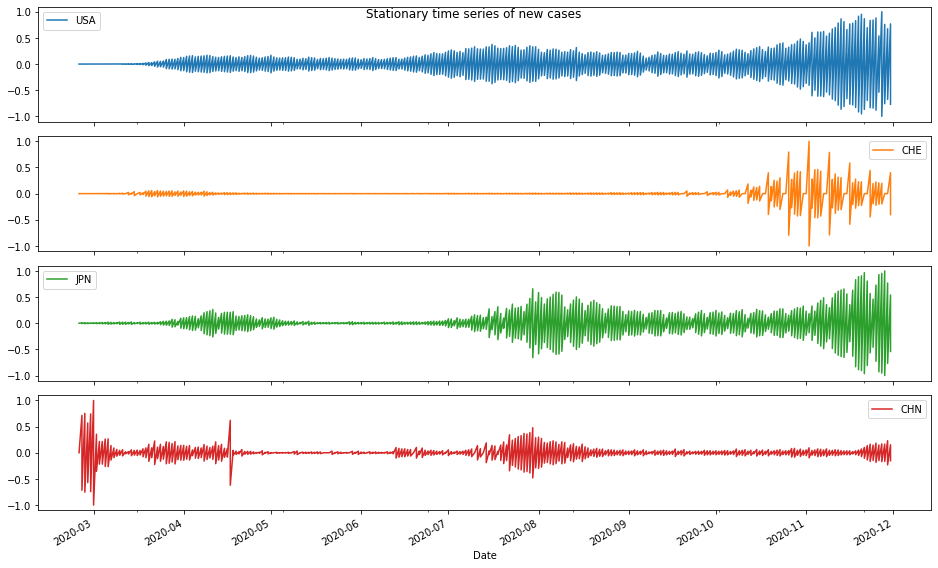

In [116]:
df_confirmed_stat.plot(subplots=True, title='Stationary time series of new cases', figsize=(13,8))
plt.tight_layout()
plt.show()

Now that everything is stationary, we can prove granger causality

### Granger Causality test
https://medium.com/swlh/using-granger-causality-test-to-know-if-one-time-series-is-impacting-in-predicting-another-6285b9fd2d1c

In [122]:
maxlag=12
test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset
grangers_causality_matrix(df_confirmed_stat, variables = df_confirmed_stat.columns)

,USA_x,CHE_x,JPN_x,CHN_x
USA_y,1.0,0.0000,0.0,0.8285
CHE_y,0.0,1.0000,0.0,0.0976
JPN_y,0.0,0.0000,1.0,0.1984
CHN_y,0.0,0.4852,0.0,1.0000


In [117]:
from statsmodels.tsa.stattools import  grangercausalitytests

In [120]:
res = grangercausalitytests(df_confirmed_stat[['CHE', 'CHN']], maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7298  , p=0.0991  , df_denom=556, df_num=1
ssr based chi2 test:   chi2=2.7445  , p=0.0976  , df=1
likelihood ratio test: chi2=2.7378  , p=0.0980  , df=1
parameter F test:         F=2.7298  , p=0.0991  , df_denom=556, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7966  , p=0.1668  , df_denom=553, df_num=2
ssr based chi2 test:   chi2=3.6256  , p=0.1632  , df=2
likelihood ratio test: chi2=3.6139  , p=0.1642  , df=2
parameter F test:         F=1.7966  , p=0.1668  , df_denom=553, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6463  , p=0.5855  , df_denom=550, df_num=3
ssr based chi2 test:   chi2=1.9635  , p=0.5800  , df=3
likelihood ratio test: chi2=1.9601  , p=0.5807  , df=3
parameter F test:         F=0.6463  , p=0.5855  , df_denom=550, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5450  , p=0.7028  

In [119]:
res = grangercausalitytests(df_confirmed_stat[['USA', 'JPN']], maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1164  , p=0.7331  , df_denom=556, df_num=1
ssr based chi2 test:   chi2=0.1170  , p=0.7323  , df=1
likelihood ratio test: chi2=0.1170  , p=0.7323  , df=1
parameter F test:         F=0.1164  , p=0.7331  , df_denom=556, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0670  , p=0.9352  , df_denom=553, df_num=2
ssr based chi2 test:   chi2=0.1352  , p=0.9346  , df=2
likelihood ratio test: chi2=0.1352  , p=0.9346  , df=2
parameter F test:         F=0.0670  , p=0.9352  , df_denom=553, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3270  , p=0.2647  , df_denom=550, df_num=3
ssr based chi2 test:   chi2=4.0317  , p=0.2581  , df=3
likelihood ratio test: chi2=4.0172  , p=0.2596  , df=3
parameter F test:         F=1.3270  , p=0.2647  , df_denom=550, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0261  , p=0.3931  

## Correlation study Total Cases

In [ ]:
df_total.head()

,USA,CHE,JPN,CHN
date,,,,
2020-02-25 00:00:00+00:00,16,1,173,77754
2020-02-25 00:00:00+00:00,16,1,173,77754
2020-02-26 00:00:00+00:00,16,1,192,78166
2020-02-26 00:00:00+00:00,16,1,192,78166
2020-02-27 00:00:00+00:00,17,8,218,78600


Normalize data

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_total.values)
df_total_scaled = pd.DataFrame(x_scaled)
df_total_scaled = df_total_scaled.rename(columns={
    0:countries_of_interest[0],
    1:countries_of_interest[1],
    2:countries_of_interest[2],
    3:countries_of_interest[3]
})
df_total_scaled['Date'] = df_total.index
df_total_scaled = df_total_scaled.set_index('Date')
df_total_scaled.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-02-25 00:00:00+00:00,0.000000e+00,0.000000,0.000000,0.000000
2020-02-25 00:00:00+00:00,0.000000e+00,0.000000,0.000000,0.000000
2020-02-26 00:00:00+00:00,0.000000e+00,0.000000,0.000128,0.027198
2020-02-26 00:00:00+00:00,0.000000e+00,0.000000,0.000128,0.027198
2020-02-27 00:00:00+00:00,7.384887e-08,0.000021,0.000302,0.055849


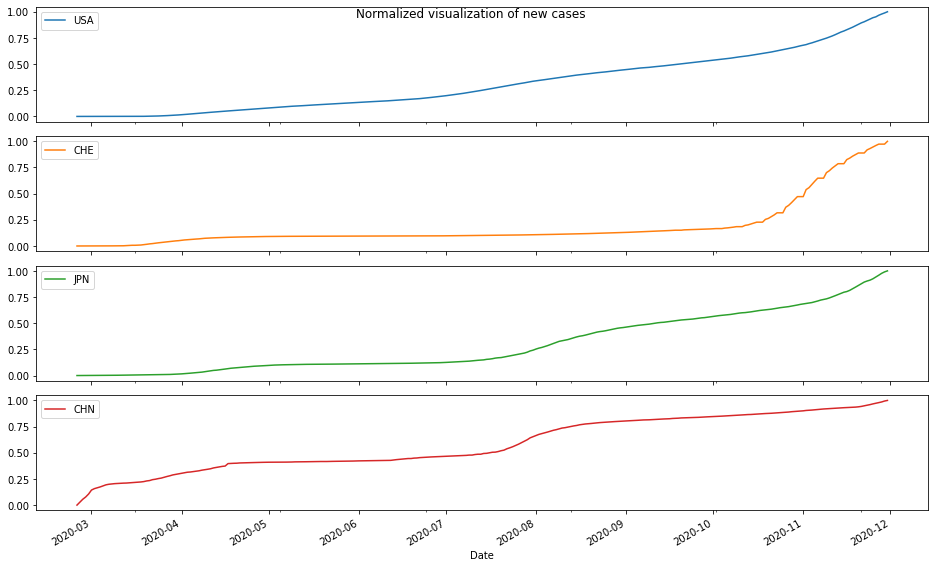

In [ ]:
df_total_scaled.plot(subplots=True, title='Normalized visualization of new cases', figsize=(13,8))
plt.tight_layout()
plt.show()

### Correlation matrix of new cases among different countries

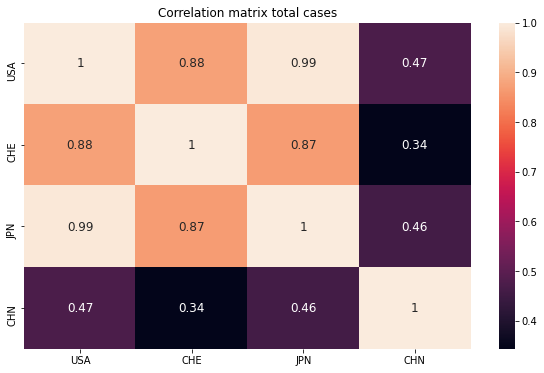

In [ ]:
corr = df_total_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.title('Correlation matrix total cases')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
df_total_scaled.head()

,USA,CHE,JPN,CHN
Date,,,,
2020-02-25 00:00:00+00:00,0.000000e+00,0.000000,0.000000,0.000000
2020-02-25 00:00:00+00:00,0.000000e+00,0.000000,0.000000,0.000000
2020-02-26 00:00:00+00:00,0.000000e+00,0.000000,0.000128,0.027198
2020-02-26 00:00:00+00:00,0.000000e+00,0.000000,0.000128,0.027198
2020-02-27 00:00:00+00:00,7.384887e-08,0.000021,0.000302,0.055849


### ACF function

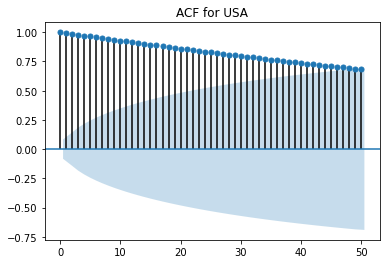

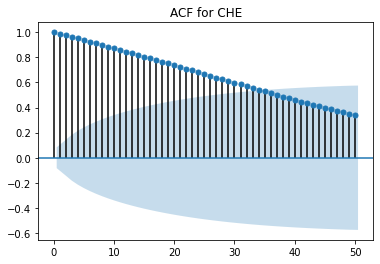

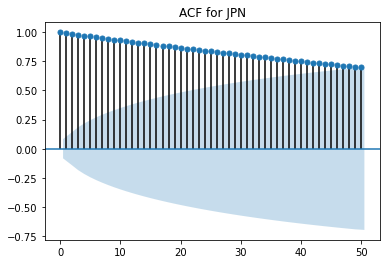

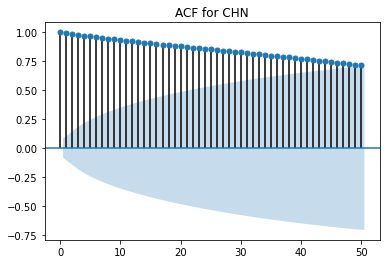

In [ ]:
for country in df_total_scaled:
    sm.graphics.tsa.plot_acf(df_total_scaled[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()